In [1]:
!nvidia-smi

Thu May 27 01:09:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P8    16W /  N/A |    460MiB /  8111MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
if not os.path.isdir('keras-retinanet'):
    !git clone https://github.com/fizyr/keras-retinanet.git

In [3]:
#!pip install --upgrade keras

In [32]:
%cd keras-retinanet/
!ls
if 1: #make this 1 and run only on very first time
    !pip install .
    !python setup.py build_ext --inplace
    !pip install gdown
    !pip install tensorflow

[Errno 2] No such file or directory: 'keras-retinanet/'
/home/skycam/sample_projs/mask_Retina/RetinaNet_mask/keras-retinanet
alldata.csv	 CONTRIBUTORS.md  maskdb	    setup.py
annotations.csv  examples	  README.md	    snapshots
build		 keras_retinanet  requirements.txt  tests
classes.csv	 LICENSE	  setup.cfg	    xml2csv.py
Processing /home/skycam/sample_projs/mask_Retina/RetinaNet_mask/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167004 sha256=d264c26049fadfd881636f943540c20e774392e5e5f48c8bce8db7de023dd518
  Stored in director

In [33]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [34]:
os.makedirs("snapshots", exist_ok=True)

In [35]:
#https://curiousily.com/posts/object-detection-on-custom-dataset-with-tensorflow-2-and-keras-using-python/
#https://colab.research.google.com/drive/1ldnii3sGJaUHPV6TWImykbeE_O-8VIIN#scrollTo=5DgiQ4FR0go6

In [36]:
os.makedirs("maskdb", exist_ok=True)

In [37]:
!python3 xml2csv.py

maskdb/train/48.xml
xml to csv maskdb/train/48.xml
maskdb/train/augmented_image_206.xml
xml to csv maskdb/train/augmented_image_206.xml
maskdb/train/pexels-photo-4048805.xml
xml to csv maskdb/train/pexels-photo-4048805.xml
maskdb/train/54.xml
xml to csv maskdb/train/54.xml
maskdb/train/43.xml
xml to csv maskdb/train/43.xml
maskdb/train/27-with-mask.xml
xml to csv maskdb/train/27-with-mask.xml
maskdb/train/30.xml
xml to csv maskdb/train/30.xml
maskdb/train/21-with-mask.xml
xml to csv maskdb/train/21-with-mask.xml
maskdb/train/32-with-mask.xml
xml to csv maskdb/train/32-with-mask.xml
maskdb/train/16-with-mask.xml
xml to csv maskdb/train/16-with-mask.xml
maskdb/train/30-with-mask.xml
xml to csv maskdb/train/30-with-mask.xml
maskdb/train/75-with-mask.xml
xml to csv maskdb/train/75-with-mask.xml
maskdb/train/72-with-mask.xml
xml to csv maskdb/train/72-with-mask.xml
maskdb/train/25-with-mask.xml
xml to csv maskdb/train/25-with-mask.xml
maskdb/train/23.xml
xml to csv maskdb/train/23.xml
maskd

In [38]:
df = pd.read_csv('alldata.csv')
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,maskdb/train/48.jpg,107,27,193,135,nomask
1,maskdb/train/augmented_image_206.jpg,87,110,262,373,mask
2,maskdb/train/pexels-photo-4048805.jpeg,924,298,1100,582,nomask
3,maskdb/train/54.jpg,78,96,267,343,nomask
4,maskdb/train/43.jpg,46,103,258,372,nomask


In [39]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  
  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(0, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

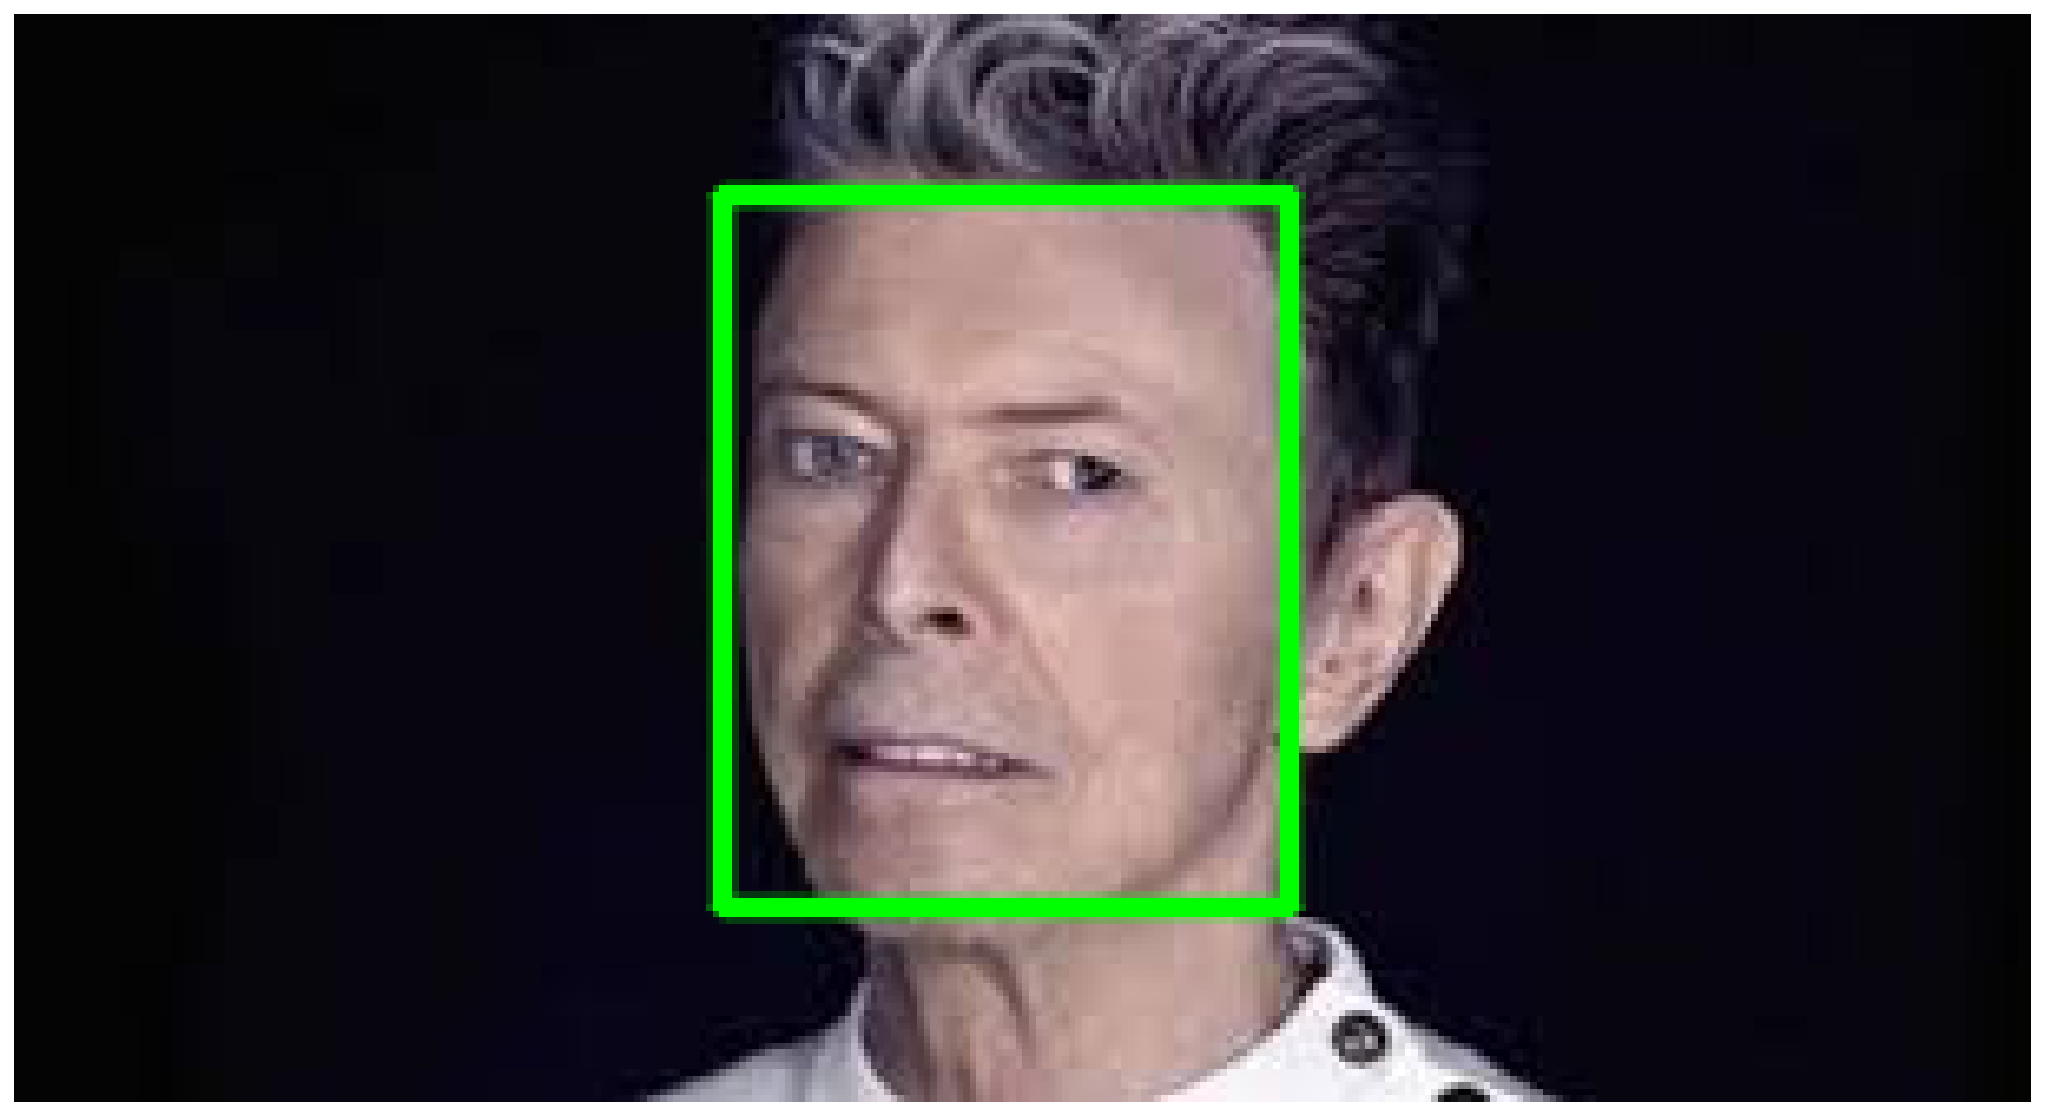

In [40]:
show_image_objects(df.iloc[0])

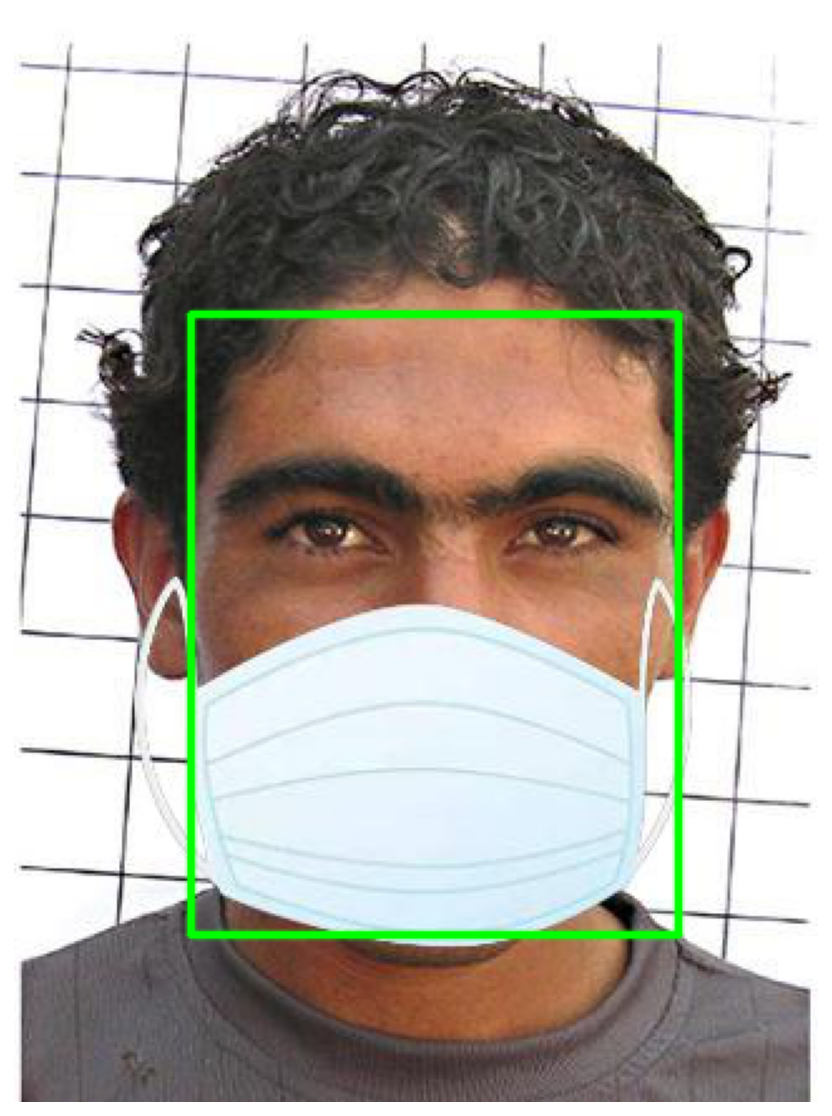

In [41]:
show_image_objects(df.iloc[5])

# Preprocessing

In [42]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [43]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [44]:
train_df

,image_name,x_min,y_min,x_max,y_max,class_name
9,maskdb/train/16-with-mask.jpg,88,116,232,308,mask
5,maskdb/train/27-with-mask.jpg,70,119,264,366,mask
34,maskdb/train/57.jpg,26,151,270,496,nomask
22,maskdb/train/74-with-mask.jpg,67,49,160,156,mask
30,maskdb/train/24.jpg,61,103,235,253,nomask
...,...,...,...,...,...,...
20,maskdb/train/augmented_image_195.jpg,31,25,154,189,mask
60,maskdb/train/40.jpg,71,99,254,359,nomask
71,maskdb/train/59.jpg,69,132,256,354,nomask
14,maskdb/train/23.jpg,56,48,139,155,nomask


In [45]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [46]:
classes = set(['mask','nomask'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [47]:
!head classes.csv

mask,0
nomask,1


In [48]:
!head annotations.csv

maskdb/train/16-with-mask.jpg,88,116,232,308,mask
maskdb/train/27-with-mask.jpg,70,119,264,366,mask
maskdb/train/57.jpg,26,151,270,496,nomask
maskdb/train/74-with-mask.jpg,67,49,160,156,mask
maskdb/train/24.jpg,61,103,235,253,nomask
maskdb/train/62.jpg,41,82,191,212,nomask
maskdb/train/augmented_image_261.jpg,54,121,246,351,mask
maskdb/train/13-with-mask.jpg,213,59,331,218,mask
maskdb/train/49.jpg,37,77,148,234,nomask
maskdb/train/36.jpg,17,77,124,221,nomask


# Training

In [49]:
if 0:
    PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
    if not os.path.isfile(PRETRAINED_MODEL):
        URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
        urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

        print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

In [50]:
PRETRAINED_MODEL = './snapshots/resnet50_csv_.h5'

In [51]:
!pip3 install progressbar2

In [ ]:
if 1:#make this one and run to train again
    !keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 4 --steps 10 --epochs 300 csv annotations.csv classes.csv

# Loading the trained model

In [ ]:
!ls snapshots

In [ ]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

# Predictions

In [ ]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score > THRES_SCORE:
        #break

        color = label_color(label)
        #print('label',label)
        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)
  #import pdb;pdb.set_trace()

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(0, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [ ]:
test_df.head(n=10)

In [ ]:
show_detected_objects(test_df.iloc[0])

In [ ]:
show_detected_objects(test_df.iloc[1])

In [ ]:
show_detected_objects(test_df.iloc[2])